In [1]:
# Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, ReLU, Add, Input, Flatten, Dense, Dropout,
    GlobalAveragePooling2D, MaxPooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report


In [2]:

# Paths
DATASET_DIR = r'F:\deep'
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

# Check if directories exist
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Test directory not found: {TEST_DIR}")

print("Dataset paths are verified.")


Dataset paths are verified.


In [3]:
# Constants
IMAGE_SIZE = 224  # Resize all images to 224x224
BATCH_SIZE = 32

# Data Loading Function
def load_data(data_dir):
    images = []
    labels = []
    for label in os.listdir(data_dir):  # Each subfolder is a class
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, file)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read in color
                if img is not None:
                    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize to 224x224
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Load Training Data
X_images, y_labels = load_data(TRAIN_DIR)
X_images = X_images / 255.0  # Normalize
print(f"Loaded {len(X_images)} images with {len(np.unique(y_labels))} classes.")


Loaded 4750 images with 12 classes.


In [4]:
# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded)

# Compute Class Weights for Imbalanced Dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights computed for imbalanced dataset.")


Class weights computed for imbalanced dataset.


In [5]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X_images, y_categorical, test_size=0.2, random_state=42, shuffle=True
)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

print(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}.")


Training set size: 3800, Validation set size: 950.


In [6]:
# Define ResNet Block
def resnet_block(input_tensor, filters, strides=(1, 1)):
    x = Conv2D(filters, (3, 3), strides=strides, padding='same', kernel_regularizer='l2')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), strides=(1, 1), padding='same', kernel_regularizer='l2')(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_regularizer='l2')(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Build Custom ResNet Model
def build_custom_resnet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_regularizer='l2')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=(2, 2))
    x = resnet_block(x, 256, strides=(2, 2))
    x = resnet_block(x, 512, strides=(2, 2))
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
    x = Dropout(0.6)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=input_layer, outputs=output)

# Compile Model
custom_resnet_model = build_custom_resnet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=y_categorical.shape[1])
custom_resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Smaller learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Custom ResNet model built and compiled.")


Custom ResNet model built and compiled.


In [7]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Training
history = custom_resnet_model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=70,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler],
    verbose=1
)

# Save the Model
custom_resnet_model.save(r'F:\deep\custom_resnet_model_2.h5')
print("Training complete. Model saved.")


Epoch 1/70


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 533s 4s/step - accuracy: 0.2057 - loss: 29.1968 - val_accuracy: 0.1463 - val_loss: 27.1199 - learning_rate: 1.0000e-04
Epoch 2/70
  1/118 ━━━━━━━━━━━━━━━━━━━━ 5:56 3s/step - accuracy: 0.5312 - loss: 25.0579

C:\Users\dell\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step - accuracy: 0.5312 - loss: 25.0579 - val_accuracy: 0.1474 - val_loss: 27.0815 - learning_rate: 1.0000e-04
Epoch 3/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.5361 - loss: 23.9899 - val_accuracy: 0.0368 - val_loss: 25.5970 - learning_rate: 1.0000e-04
Epoch 4/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.7500 - loss: 20.7431 - val_accuracy: 0.0368 - val_loss: 25.6744 - learning_rate: 1.0000e-04
Epoch 5/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 402s 3s/step - accuracy: 0.6324 - loss: 20.1220 - val_accuracy: 0.1453 - val_loss: 23.7631 - learning_rate: 1.0000e-04
Epoch 6/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 170ms/step - accuracy: 0.6562 - loss: 17.8196 - val_accuracy: 0.1453 - val_loss: 23.8246 - learning_rate: 1.0000e-04
Epoch 7/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - accuracy: 0.6929 - loss: 17.0038 - val_accuracy: 0.1537 - val_loss: 19.7052 - learning_rate: 1.0000e-04
Epoch 8/70
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/s

Training complete. Model saved.


In [9]:
# Training
history = custom_resnet_model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=30,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler],
    verbose=1
)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 427s 4s/step - accuracy: 0.9340 - loss: 1.8973 - val_accuracy: 0.7453 - val_loss: 2.5543 - learning_rate: 5.0000e-05
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.8750 - loss: 2.1200 - val_accuracy: 0.7558 - val_loss: 2.5253 - learning_rate: 5.0000e-05
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.9229 - loss: 1.8785 - val_accuracy: 0.8600 - val_loss: 2.0478 - learning_rate: 5.0000e-05
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.9688 - loss: 1.7733 - val_accuracy: 0.8684 - val_loss: 2.0079 - learning_rate: 5.0000e-05
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.9295 - loss: 1.8329 - val_accuracy: 0.8568 - val_loss: 2.0480 - learning_rate: 5.0000e-05
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.9688 - loss: 1.7220 - val_accuracy: 0.8579 - val_loss: 2.0507 - learning_rate: 5.0000e-05
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step

In [43]:
# Evaluate on Validation Set
val_loss, val_accuracy = custom_resnet_model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")



30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.7720 - loss: 1.9300
Validation Loss: 1.9527313709259033, Validation Accuracy: 0.7610526084899902


In [11]:
def load_data(data_dir):
    images = []
    filenames = []  # لحفظ أسماء الملفات
    for file in os.listdir(data_dir):
        img_path = os.path.join(data_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # قراءة الصورة بالألوان
        if img is not None:
            img = cv2.resize(img, (224, 224))  # تغيير الحجم
            images.append(img)
            filenames.append(file)  # إضافة اسم الملف
    return np.array(images), filenames


In [12]:
# تحميل بيانات الاختبار
X_test, test_filenames = load_data(TEST_DIR)
X_test = X_test / 255.0  # تطبيع البيانات


In [13]:
# التنبؤ على بيانات الاختبار
predictions = custom_resnet_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# حفظ التنبؤات
submission = pd.DataFrame({
    'Filename': test_filenames,
    'Label': predicted_labels
})
submission.to_csv(r'F:\deep\submission.csv', index=False)
print("Predictions saved successfully.")


25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 681ms/step
Predictions saved successfully.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc


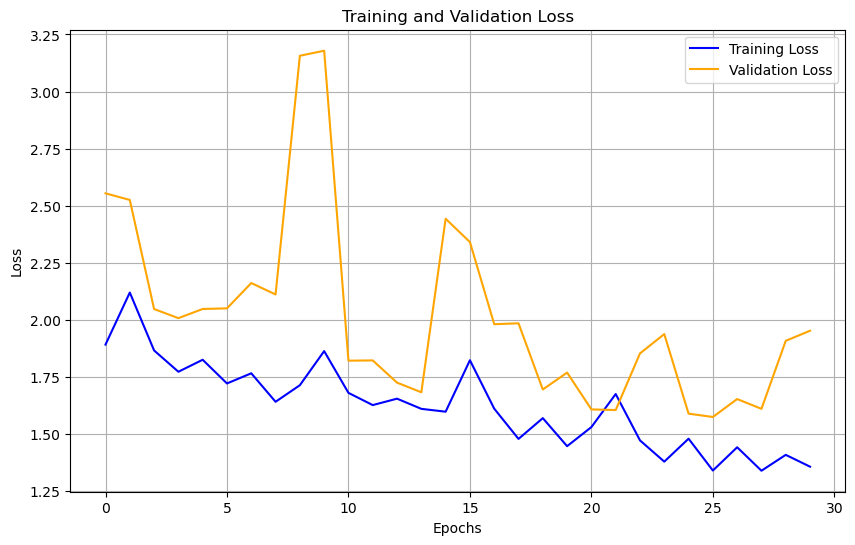

In [16]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


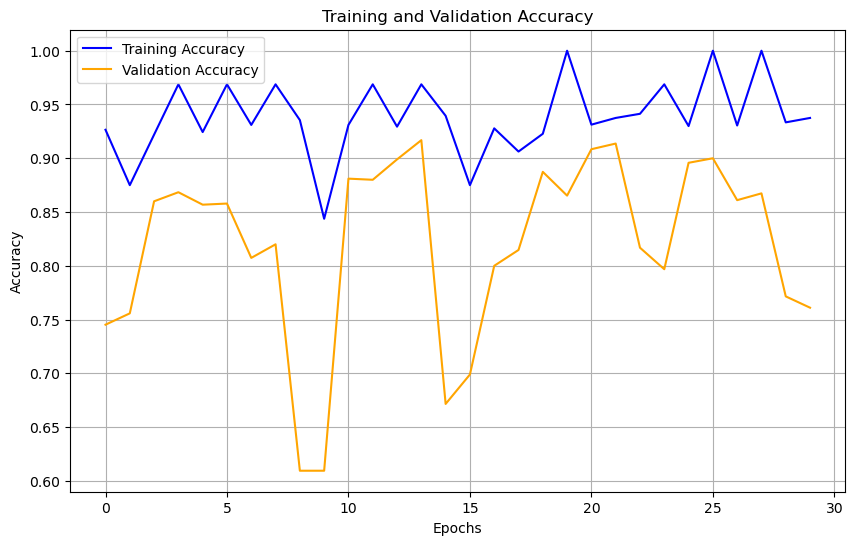

In [17]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate Validation Predictions
val_predictions = np.argmax(custom_resnet_model.predict(X_val), axis=1)
val_true = np.argmax(y_val, axis=1)

# Classification Report
report = classification_report(val_true, val_predictions, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

# Compute Precision, Recall, F1-Score
precision, recall, fscore, _ = precision_recall_fscore_support(val_true, val_predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {fscore:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(val_true, val_predictions)


30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 599ms/step
Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.34      0.79      0.47        67
                 Charlock       0.80      0.97      0.88        79
                 Cleavers       0.98      0.91      0.95        57
         Common Chickweed       0.99      0.85      0.91       125
             Common wheat       0.29      1.00      0.45        35
                  Fat Hen       0.84      0.66      0.74        80
         Loose Silky-bent       1.00      0.27      0.43       140
                    Maize       1.00      0.91      0.95        46
        Scentless Mayweed       0.93      0.90      0.92        94
          Shepherds Purse       1.00      0.62      0.76        42
Small-flowered Cranesbill       0.99      0.88      0.93       101
               Sugar beet       0.99      0.80      0.88        84

                 accuracy                           0.76      

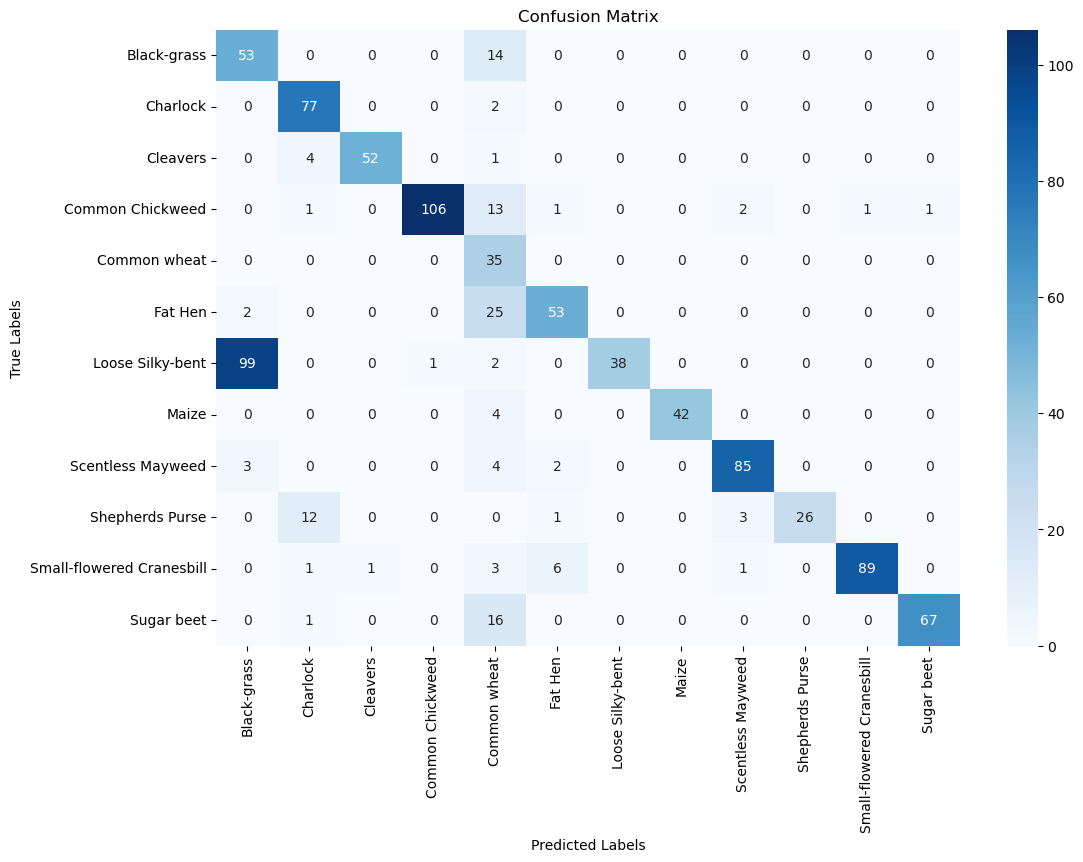

In [21]:
# Confusion Matrix Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 554ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 576ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 493ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 570ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 630ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 628ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 600ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 540ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 489ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 497ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 543ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 539ms/step


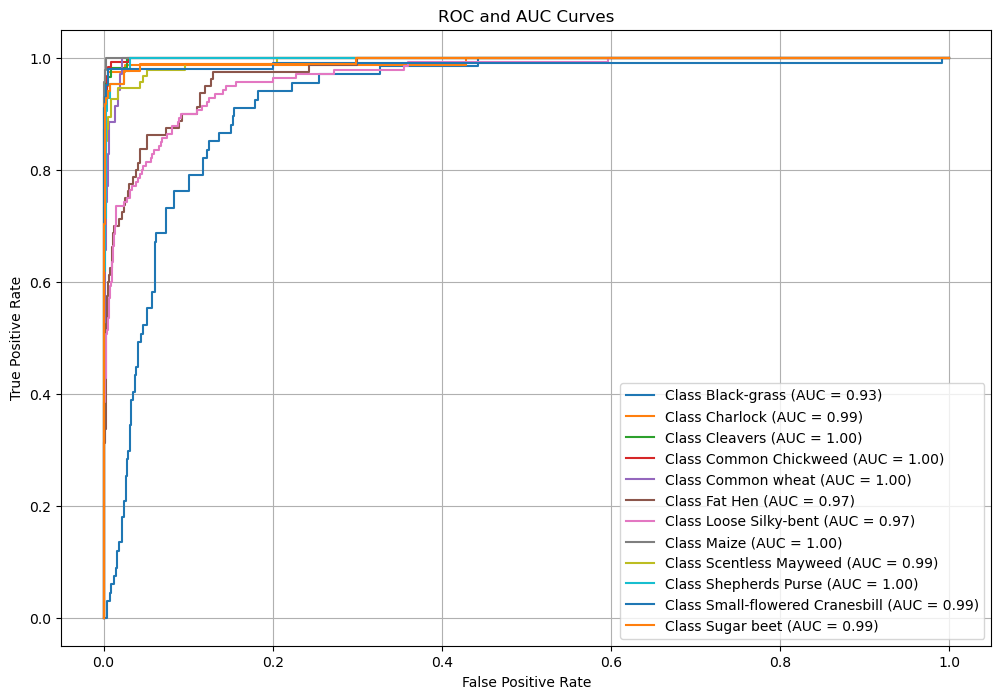

In [22]:
# Compute ROC and AUC for each class
plt.figure(figsize=(12, 8))
for i in range(y_val.shape[1]):
    fpr, tpr, _ = roc_curve(y_val[:, i], custom_resnet_model.predict(X_val)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.title('ROC and AUC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid()
plt.show()


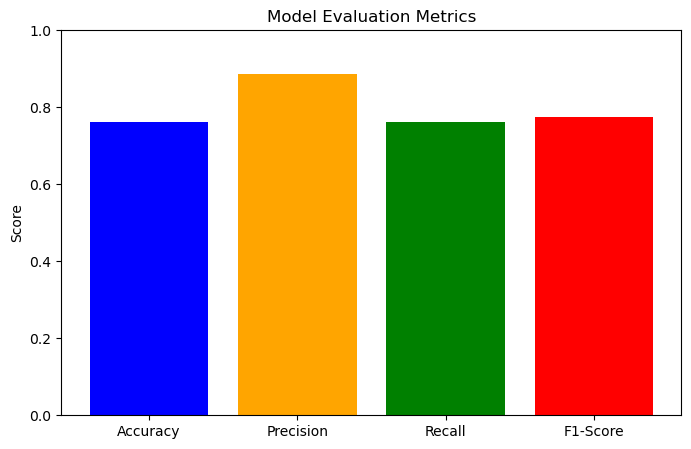

In [23]:
# Display Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [val_accuracy, precision, recall, fscore]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # All metrics are between 0 and 1
plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 529ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 499ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 577ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 510ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 486ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 498ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 489ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 483ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 495ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 503ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 491ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 491ms/step


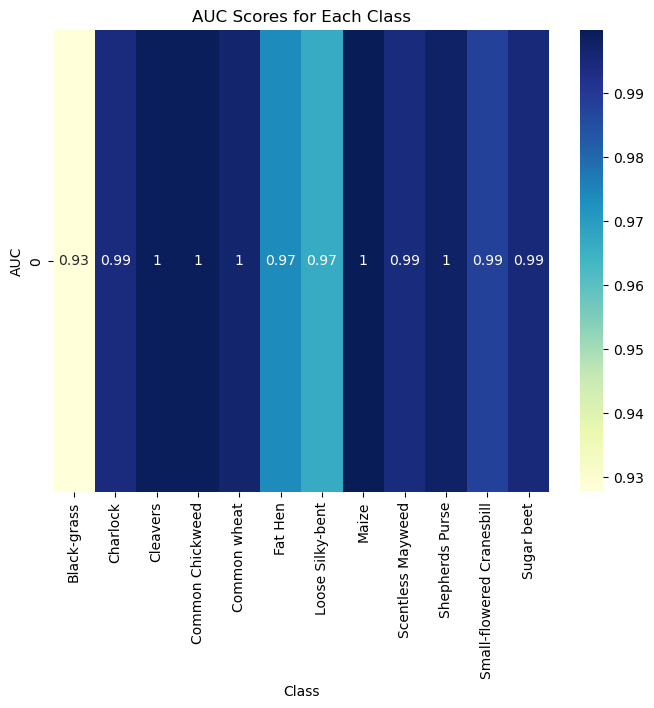

In [24]:
# Compute AUC for all classes
auc_scores = []
for i in range(y_val.shape[1]):
    fpr, tpr, _ = roc_curve(y_val[:, i], custom_resnet_model.predict(X_val)[:, i])
    auc_scores.append(auc(fpr, tpr))

# Heatmap of AUC
plt.figure(figsize=(8, 6))
sns.heatmap([auc_scores], annot=True, cmap='YlGnBu', xticklabels=label_encoder.classes_)
plt.title('AUC Scores for Each Class')
plt.xlabel('Class')
plt.ylabel('AUC')
plt.show()


# built in model Xception

In [26]:
from tensorflow.keras.applications import Xception

# Define Xception Model with Transfer Learning
def build_xception_model(input_shape, num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

xception_model = build_xception_model((IMAGE_SIZE, IMAGE_SIZE, 3), y_categorical.shape[1])
xception_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Xception Model
history_xception = xception_model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=10,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    class_weight=class_weights_dict,
    verbose=1
)

# Evaluate Xception Model
val_loss_xception, val_accuracy_xception = xception_model.evaluate(X_val, y_val, verbose=1)
print(f"Xception Model - Validation Loss: {val_loss_xception}, Validation Accuracy: {val_accuracy_xception}")


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 686s 6s/step - accuracy: 0.1458 - loss: 2.4393 - val_accuracy: 0.4116 - val_loss: 1.9110
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 97s 802ms/step - accuracy: 0.4375 - loss: 1.7588 - val_accuracy: 0.4084 - val_loss: 1.9087
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 518s 4s/step - accuracy: 0.3546 - loss: 1.9202 - val_accuracy: 0.5000 - val_loss: 1.6090
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 97s 805ms/step - accuracy: 0.4062 - loss: 1.7703 - val_accuracy: 0.5000 - val_loss: 1.6078
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 473s 4s/step - accuracy: 0.4338 - loss: 1.6756 - val_accuracy: 0.5358 - val_loss: 1.4822
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 90s 745ms/step - accuracy: 0.5625 - loss: 1.4159 - val_accuracy: 0.5326 - val_loss: 1.4815
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 455s 4s/step - accuracy: 0.4694 - loss: 1.5349 - val_accuracy: 0.5632 - val_loss: 1.3579
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 92s 759ms/step - accuracy: 0.5000 - loss: 1.3475 - 

# built in model DenseNet121

In [27]:
from tensorflow.keras.applications import DenseNet121

# Define DenseNet Model with Transfer Learning
def build_densenet_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

densenet_model = build_densenet_model((IMAGE_SIZE, IMAGE_SIZE, 3), y_categorical.shape[1])
densenet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train DenseNet Model
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=10,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    class_weight=class_weights_dict,
    verbose=1
)

# Evaluate DenseNet Model
val_loss_densenet, val_accuracy_densenet = densenet_model.evaluate(X_val, y_val, verbose=1)
print(f"DenseNet Model - Validation Loss: {val_loss_densenet}, Validation Accuracy: {val_accuracy_densenet}")


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 526s 4s/step - accuracy: 0.1312 - loss: 2.6864 - val_accuracy: 0.4105 - val_loss: 1.9374
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 688ms/step - accuracy: 0.2188 - loss: 2.0036 - val_accuracy: 0.4147 - val_loss: 1.9322
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.2935 - loss: 2.0112 - val_accuracy: 0.5526 - val_loss: 1.6121
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 103s 856ms/step - accuracy: 0.2188 - loss: 1.9608 - val_accuracy: 0.5505 - val_loss: 1.6091
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 458s 4s/step - accuracy: 0.3898 - loss: 1.7763 - val_accuracy: 0.5895 - val_loss: 1.4287
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 679ms/step - accuracy: 0.4688 - loss: 1.4380 - val_accuracy: 0.5884 - val_loss: 1.4274
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 409s 3s/step - accuracy: 0.4416 - loss: 1.6069 - val_accuracy: 0.6400 - val_loss: 1.2721
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 659ms/step - accuracy: 0.4062 - loss: 1.4482 -

In [31]:
xception_model.save(r'F:\deep\xception_model.h5')
densenet_model.save(r'F:\deep\densenet_model.h5')
print("Models saved successfully.")


Models saved successfully.


Evaluating Xception Model:
30/30 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step
Classification Report for Xception:
                           precision    recall  f1-score   support

              Black-grass       0.54      0.43      0.48        67
                 Charlock       0.76      0.80      0.78        79
                 Cleavers       0.66      0.82      0.73        57
         Common Chickweed       0.60      0.59      0.59       125
             Common wheat       0.31      0.71      0.43        35
                  Fat Hen       0.58      0.42      0.49        80
         Loose Silky-bent       0.69      0.59      0.63       140
                    Maize       0.94      0.70      0.80        46
        Scentless Mayweed       0.49      0.44      0.46        94
          Shepherds Purse       0.30      0.24      0.27        42
Small-flowered Cranesbill       0.60      0.74      0.66       101
               Sugar beet       0.76      0.76      0.76        84

                 accurac

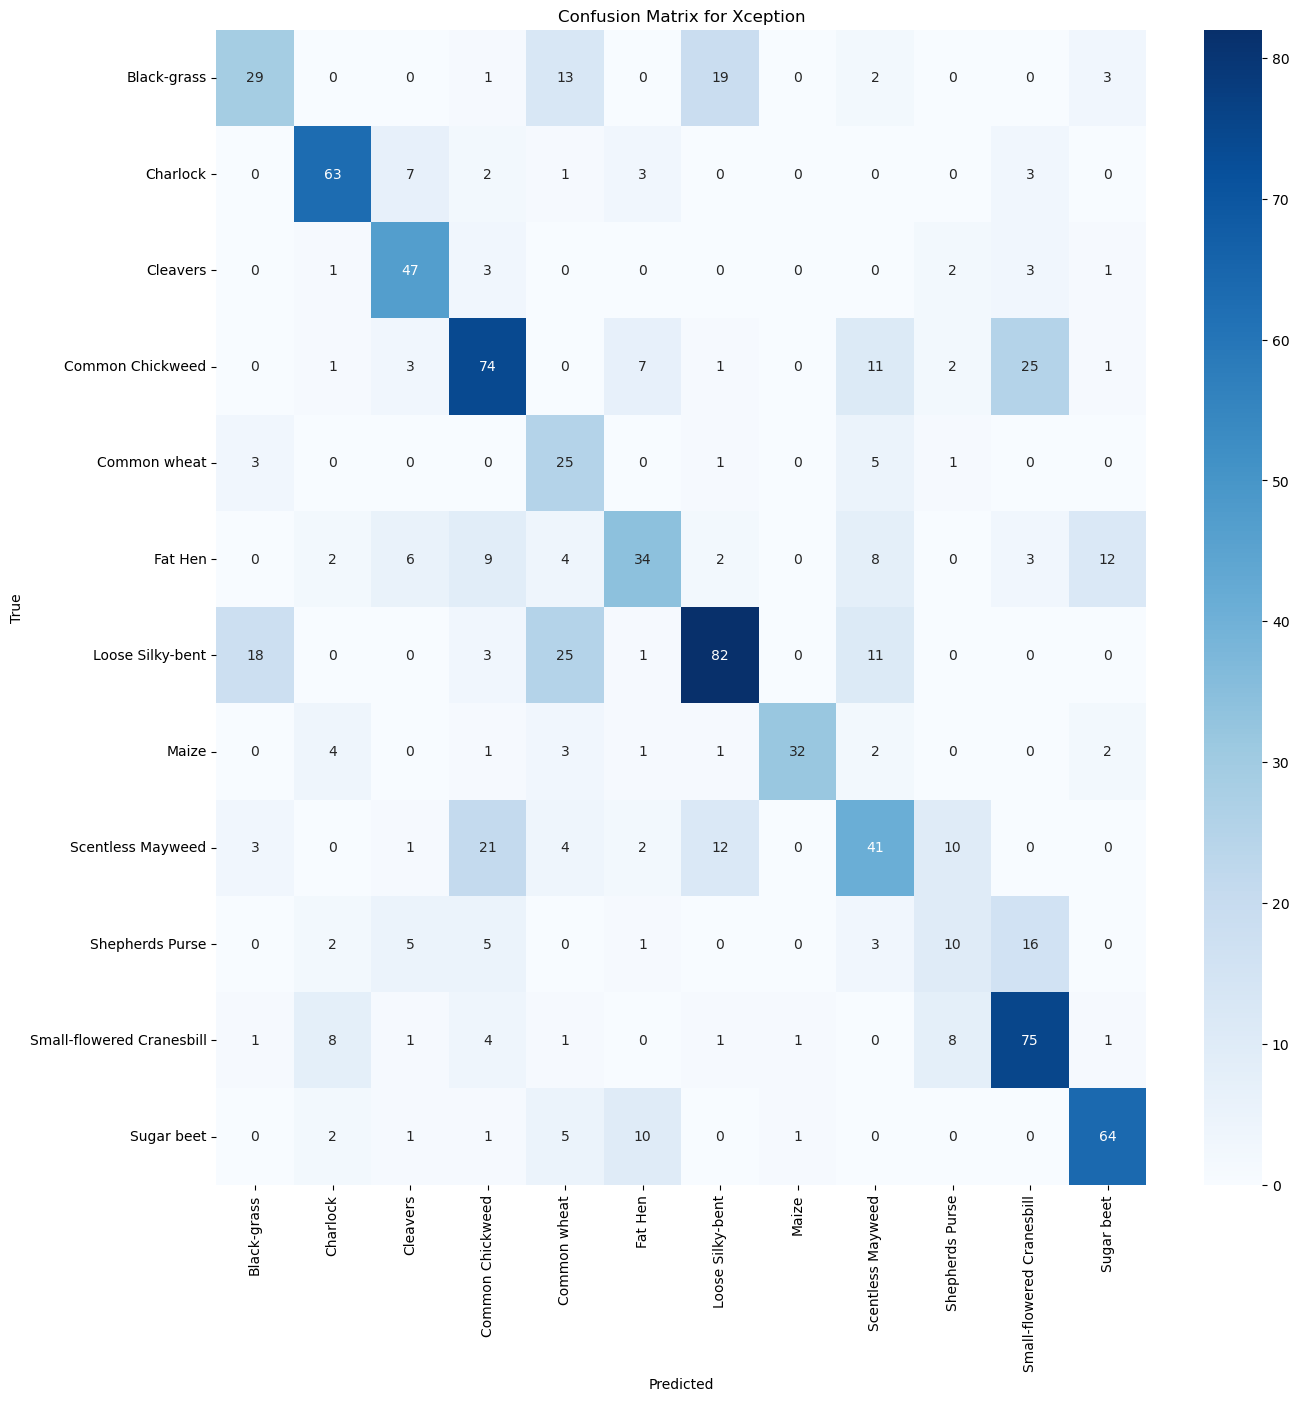

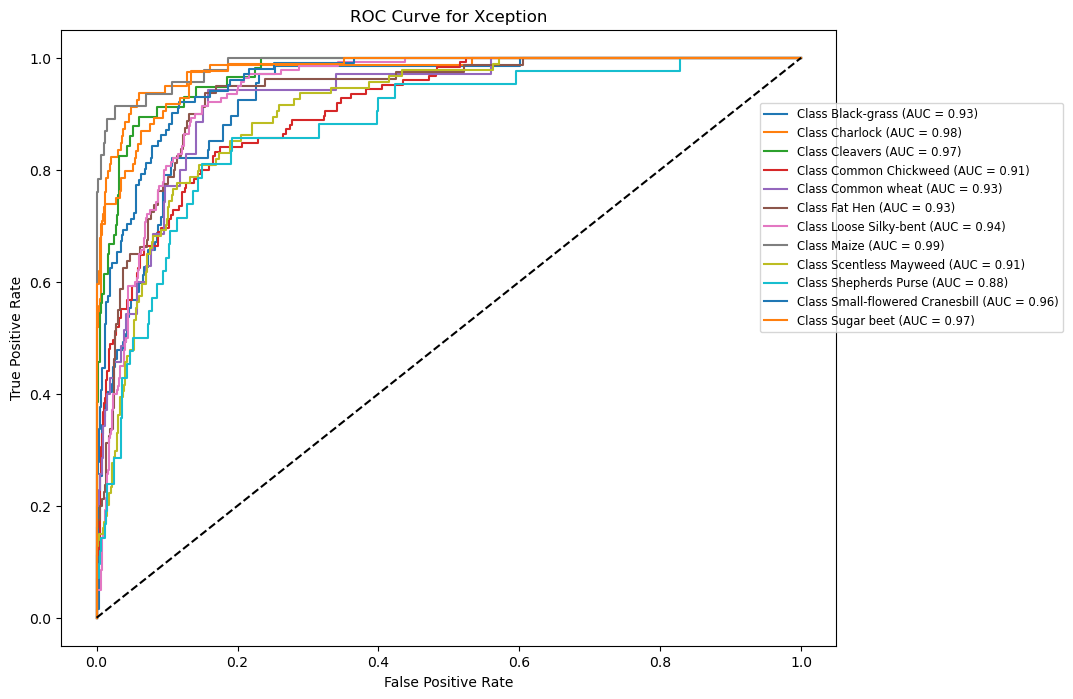

Overall Metrics for Xception:
Accuracy: 0.61
Evaluating DenseNet Model:
30/30 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step
Classification Report for DenseNet:
                           precision    recall  f1-score   support

              Black-grass       0.45      0.57      0.50        67
                 Charlock       0.87      0.76      0.81        79
                 Cleavers       0.75      0.88      0.81        57
         Common Chickweed       0.73      0.76      0.74       125
             Common wheat       0.68      0.54      0.60        35
                  Fat Hen       0.70      0.29      0.41        80
         Loose Silky-bent       0.67      0.70      0.69       140
                    Maize       0.84      0.59      0.69        46
        Scentless Mayweed       0.65      0.50      0.57        94
          Shepherds Purse       0.45      0.50      0.47        42
Small-flowered Cranesbill       0.64      0.80      0.71       101
               Sugar beet       0.62      0.85 

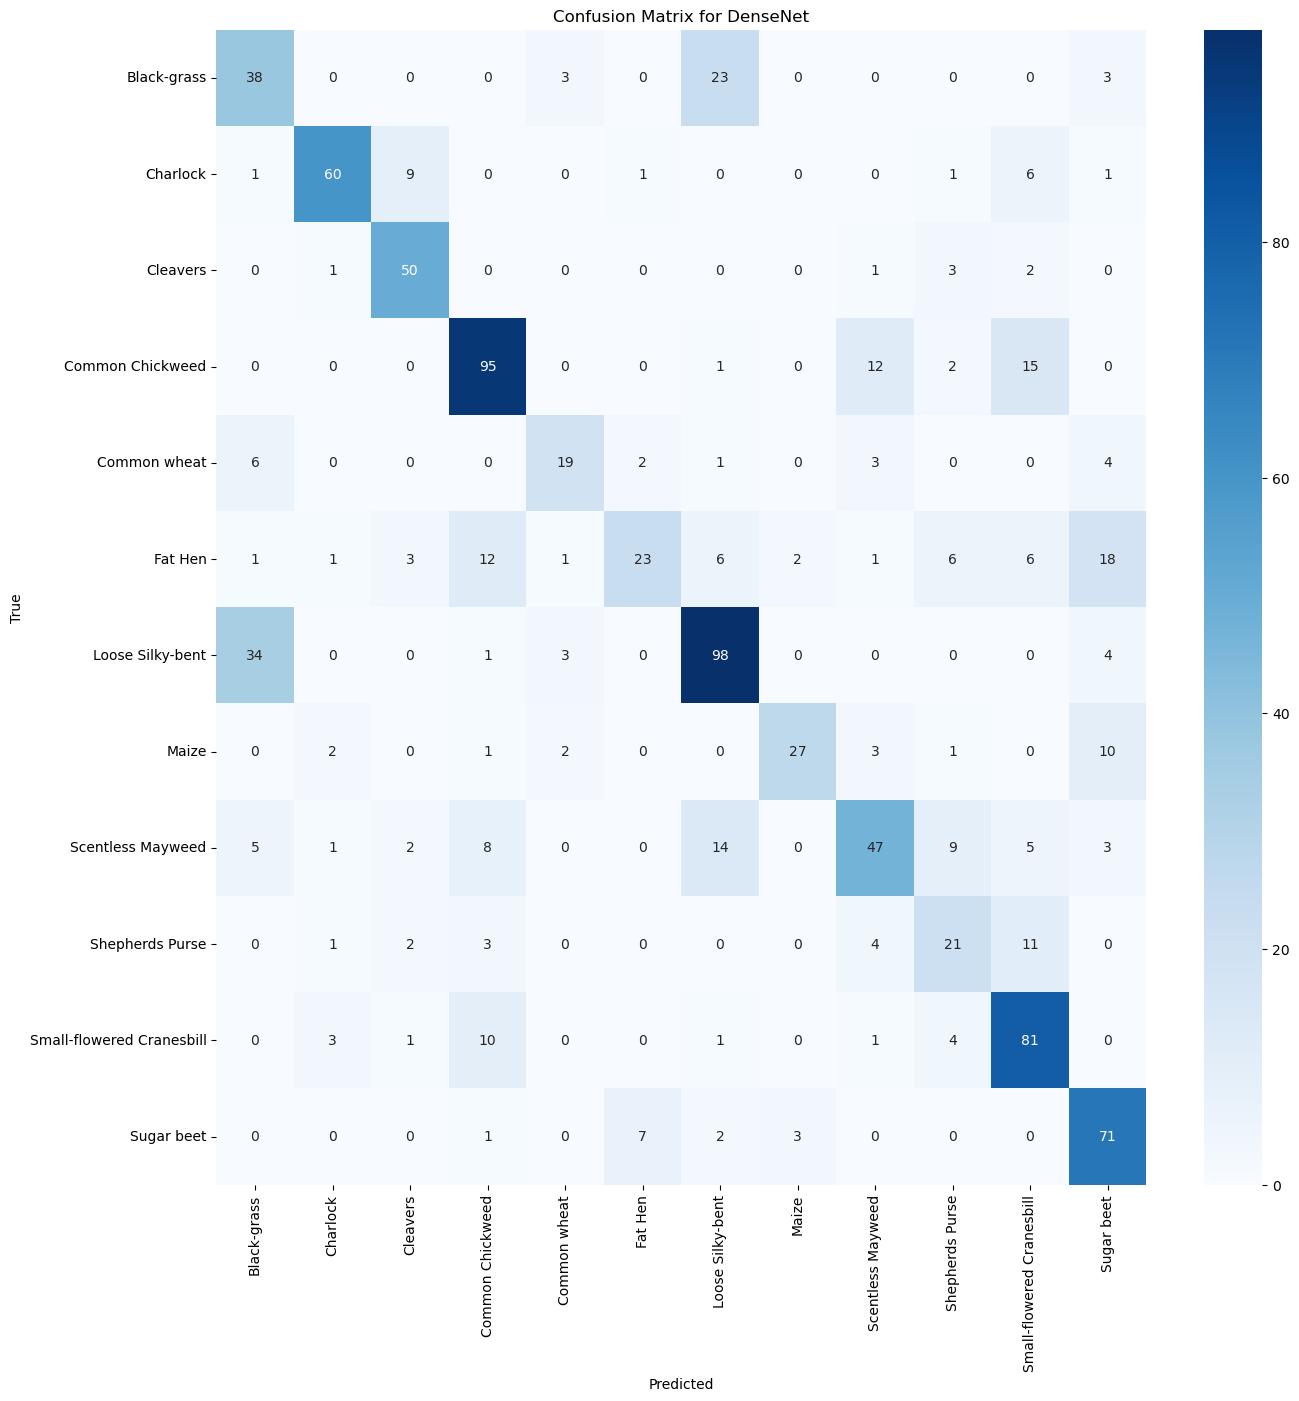

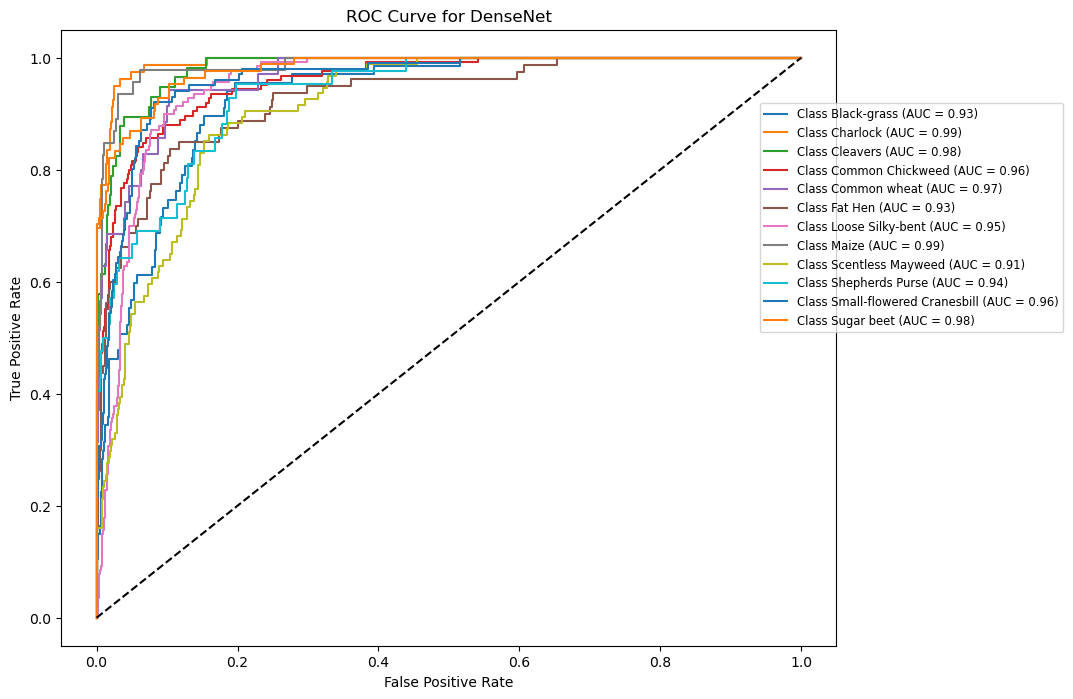

Overall Metrics for DenseNet:
Accuracy: 0.66


In [32]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc
)
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate and display metrics for a given model
def evaluate_model(model, X_val, y_val, label_encoder, model_name):
    # Get predictions
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Decode labels
    y_true_labels = label_encoder.inverse_transform(y_true)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Classification report
    print(f"Classification Report for {model_name}:")
    report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(label_encoder.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curve
    plt.figure(figsize=(10, 8))
    for i in range(len(label_encoder.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0.5), fontsize='small')
    plt.show()

    print(f"Overall Metrics for {model_name}:")
    # Calculate overall metrics
    accuracy = np.mean(y_true == y_pred)
    print(f"Accuracy: {accuracy:.2f}")

# Evaluate Xception Model
print("Evaluating Xception Model:")
evaluate_model(xception_model, X_val, y_val, label_encoder, "Xception")

# Evaluate DenseNet Model
print("Evaluating DenseNet Model:")
evaluate_model(densenet_model, X_val, y_val, label_encoder, "DenseNet")


# compare between 3 model

In [38]:
def evaluate_model(model, X_val, y_val, label_encoder, model_name):
    from sklearn.metrics import (
        classification_report, confusion_matrix, roc_curve, auc
    )
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Get predictions
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Decode labels
    y_true_labels = label_encoder.inverse_transform(y_true)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Classification report
    report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_, output_dict=True)
    
    # Accuracy
    accuracy = report['accuracy']
    
    # Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(label_encoder.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curve
    plt.figure(figsize=(10, 8))
    for i in range(len(label_encoder.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', fontsize='small')
    plt.show()

    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")

    # Return all metrics
    return {
        "model": model_name,
        "accuracy": accuracy,
        "precision": report['weighted avg']['precision'],
        "recall": report['weighted avg']['recall'],
        "f1_score": report['weighted avg']['f1-score'],
        "auc": np.mean(list(roc_auc.values())),  # Mean AUC across classes
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc
    }


30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 567ms/step


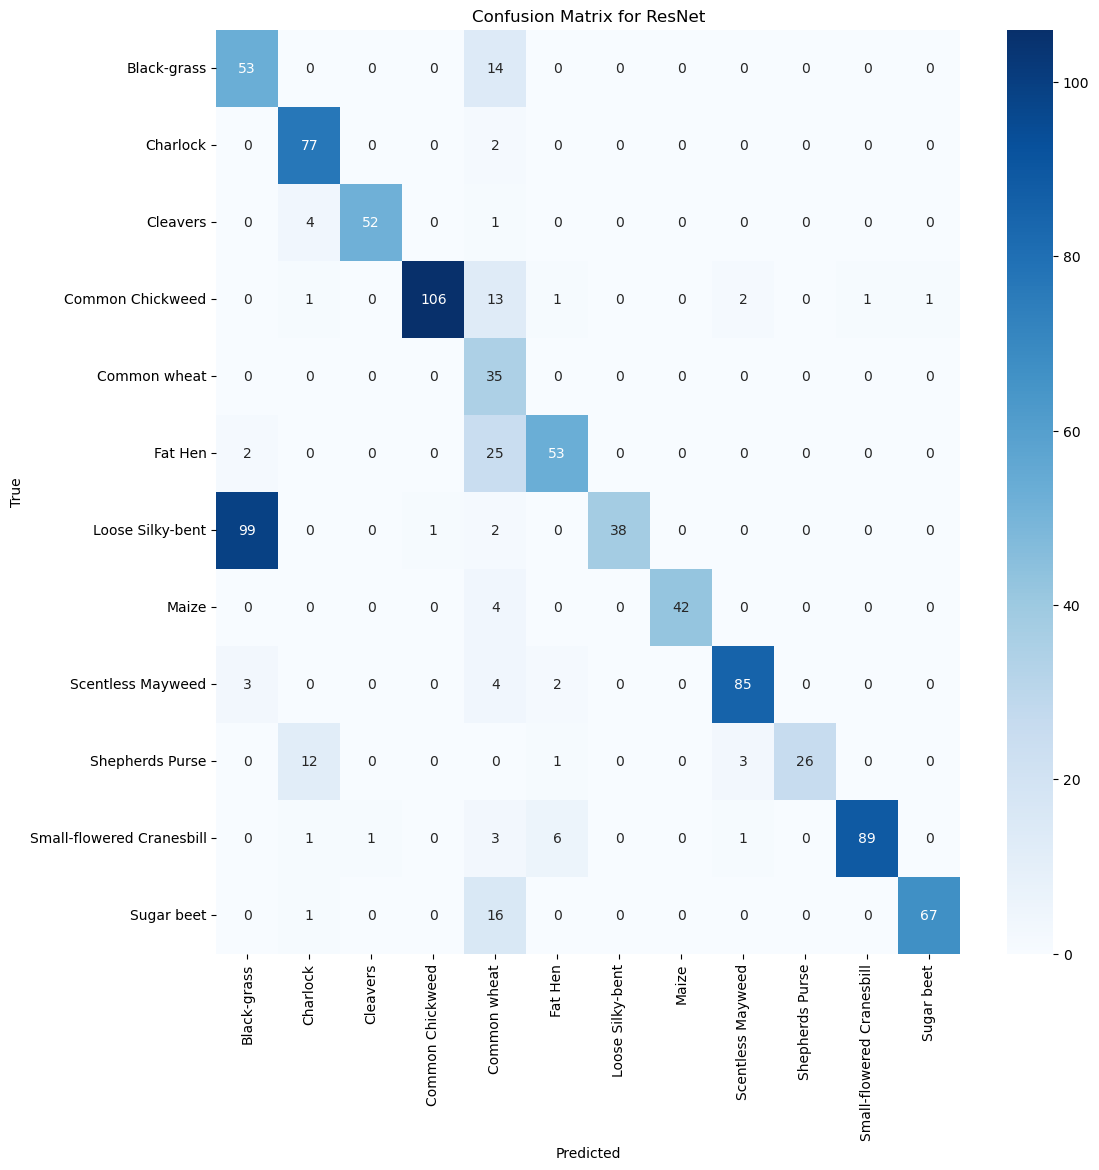

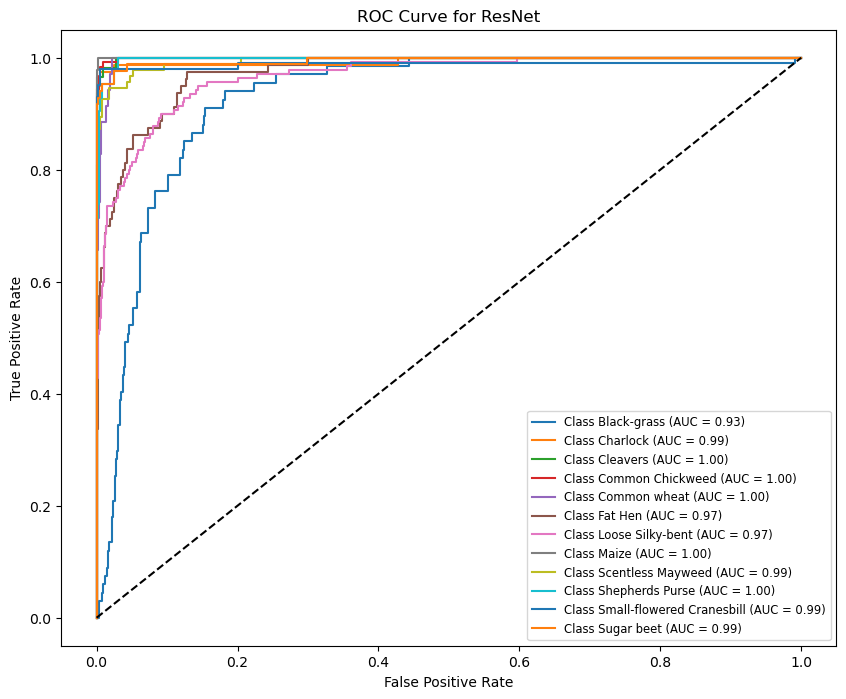

Metrics for ResNet:
Accuracy: 0.76
30/30 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step


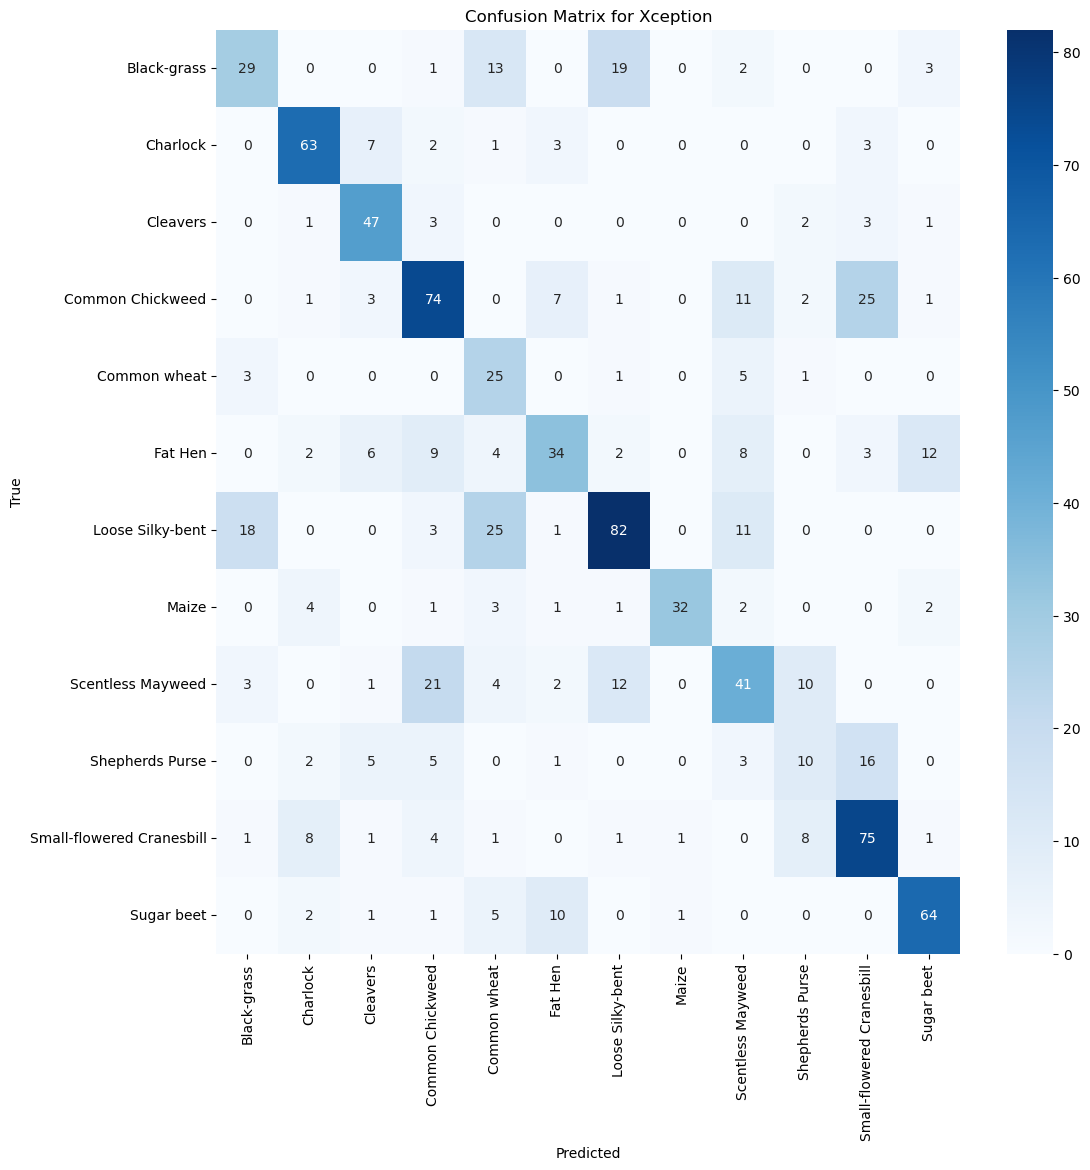

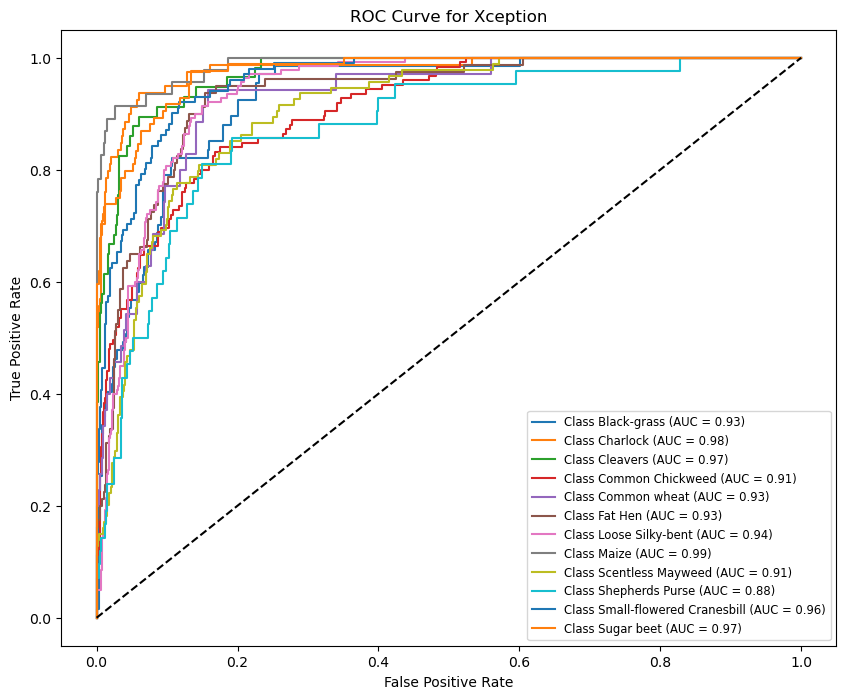

Metrics for Xception:
Accuracy: 0.61
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step


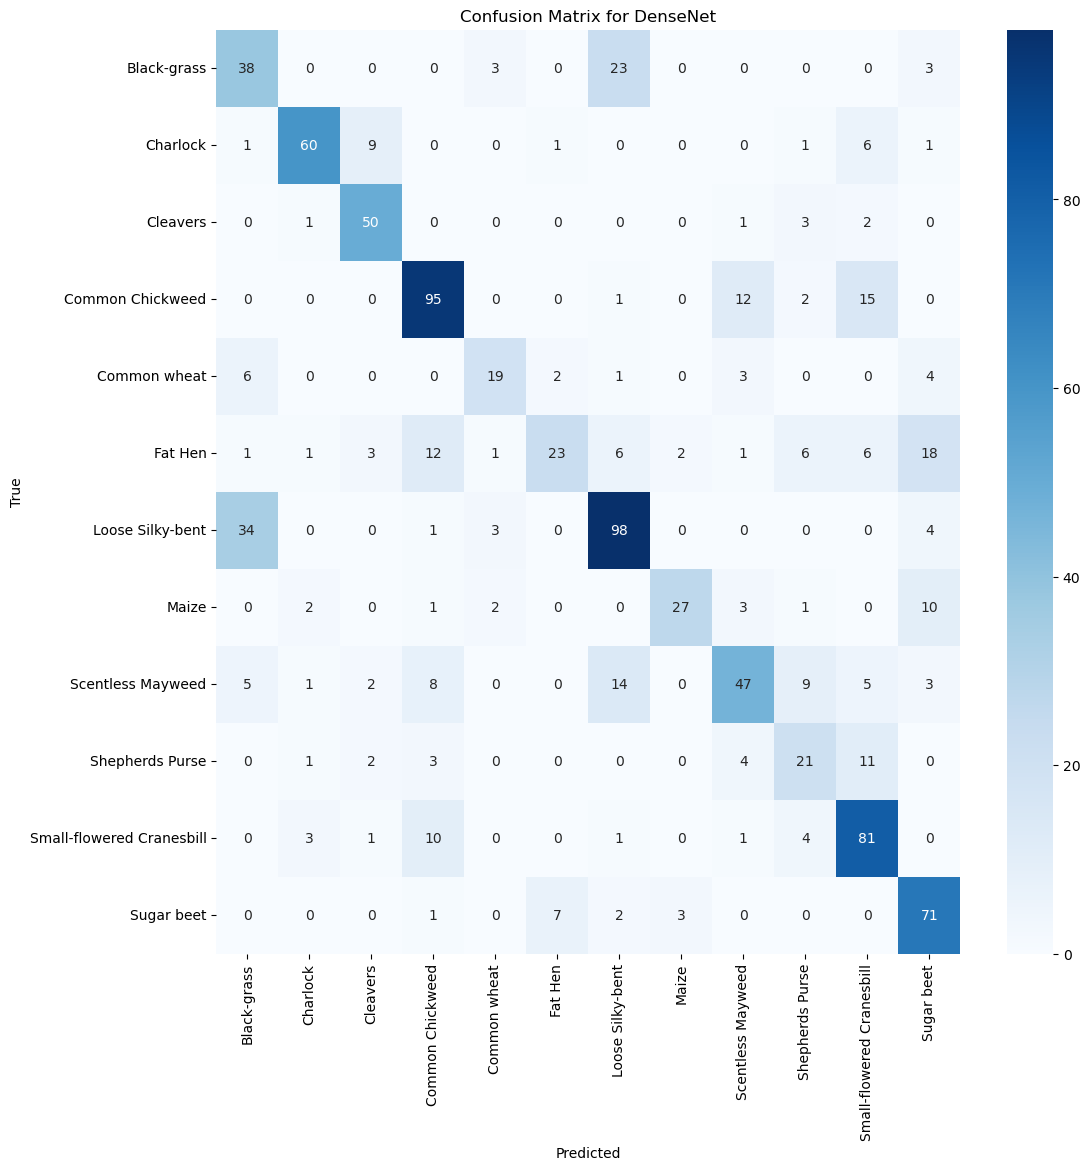

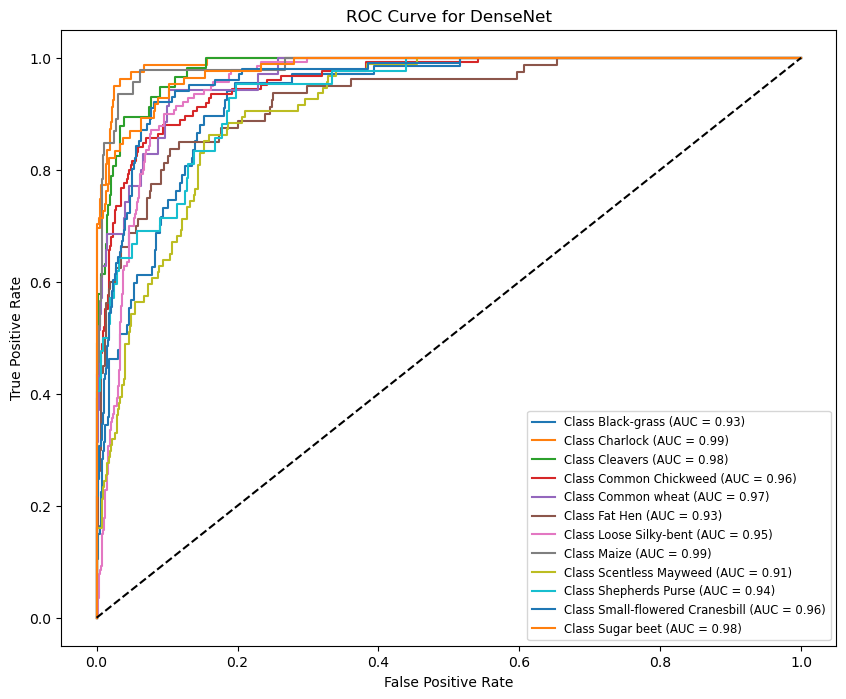

Metrics for DenseNet:
Accuracy: 0.66
      model  accuracy  precision    recall  f1_score       auc  \
0    ResNet  0.761053   0.886083  0.761053  0.773588  0.986016   
1  Xception  0.606316   0.619689  0.606316  0.605444  0.940739   
2  DenseNet  0.663158   0.675262  0.663158  0.655930  0.957135   

                                                 fpr  \
0  {0: [0.0, 0.0011325028312570782, 0.00339750849...   
1  {0: [0.0, 0.0011325028312570782, 0.00113250283...   
2  {0: [0.0, 0.0, 0.0, 0.0011325028312570782, 0.0...   

                                                 tpr  \
0  {0: [0.0, 0.0, 0.0, 0.029850746268656716, 0.02...   
1  {0: [0.0, 0.0, 0.014925373134328358, 0.0149253...   
2  {0: [0.0, 0.014925373134328358, 0.059701492537...   

                                             roc_auc  
0  {0: 0.9277226551275333, 1: 0.9940705430975598,...  
1  {0: 0.9287030307128007, 1: 0.9789562411893793,...  
2  {0: 0.9292101215327665, 1: 0.9923847171154937,...  


In [39]:
# Evaluate ResNet
resnet_metrics = evaluate_model(custom_resnet_model, X_val, y_val, label_encoder, "ResNet")

# Evaluate Xception
xception_metrics = evaluate_model(xception_model, X_val, y_val, label_encoder, "Xception")

# Evaluate DenseNet
densenet_metrics = evaluate_model(densenet_model, X_val, y_val, label_encoder, "DenseNet")

# Combine results for comparison
all_metrics = pd.DataFrame([resnet_metrics, xception_metrics, densenet_metrics])
print(all_metrics)


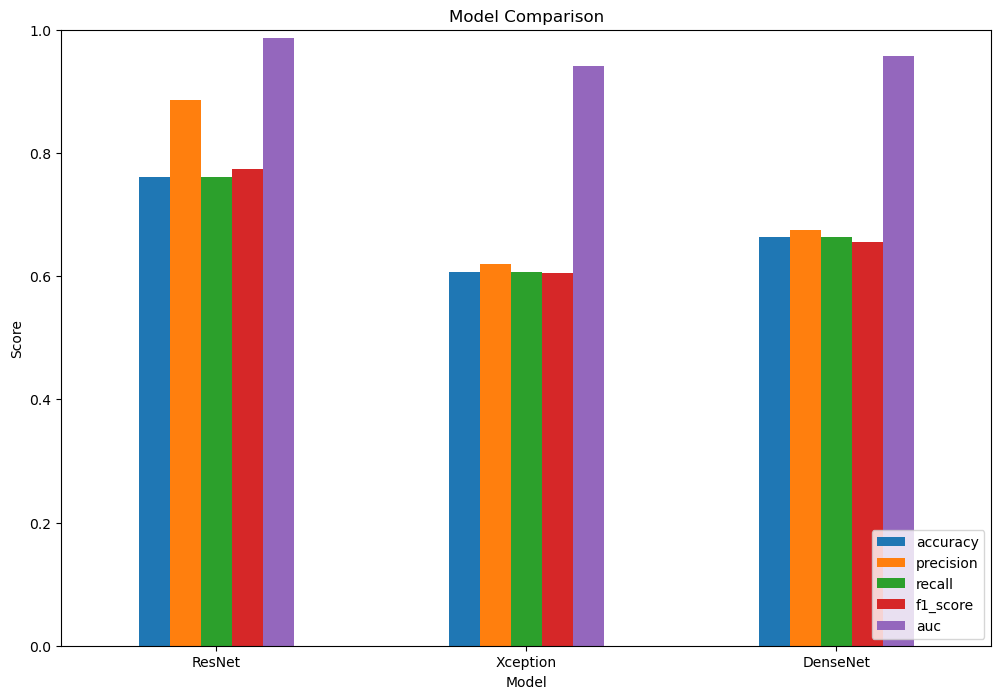

In [35]:
import matplotlib.pyplot as plt

# Metrics to compare
metrics_to_compare = ["accuracy", "precision", "recall", "f1_score", "auc"]

# Plot comparison
all_metrics.set_index("model")[metrics_to_compare].plot(kind="bar", figsize=(12, 8))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=0)
plt.show()


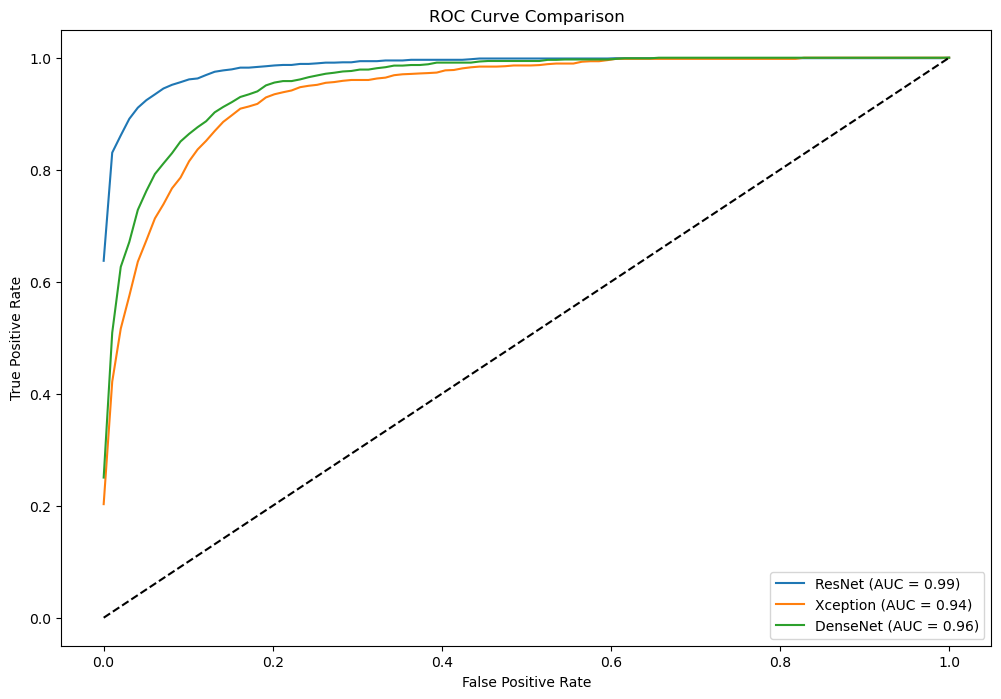

In [42]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for metrics, model in zip([resnet_metrics, xception_metrics, densenet_metrics], ["ResNet", "Xception", "DenseNet"]):
    # Use the mean ROC curve and AUC
    mean_fpr = np.linspace(0, 1, 100)
    
    # Interpolate each TPR to the same grid
    mean_tpr = np.mean([
        np.interp(mean_fpr, metrics["fpr"][i], metrics["tpr"][i]) for i in metrics["fpr"]
    ], axis=0)
    
    mean_auc = metrics["auc"]
    plt.plot(mean_fpr, mean_tpr, label=f'{model} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


In [37]:
from tabulate import tabulate

# Print in tabular form
print(tabulate(all_metrics, headers="keys", tablefmt="pretty"))


+---+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |  model   |      accuracy      |     precision      |       recall       |      f1_score      |        auc         |
+---+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0 |  ResNet  | 0.7610526315789473 | 0.8860832717284567 | 0.7610526315789473 | 0.773588292262073  | 0.9860161367400782 |
| 1 | Xception | 0.6063157894736843 | 0.6196888242772159 | 0.6063157894736843 | 0.6054438712636255 | 0.9407386345208616 |
| 2 | DenseNet | 0.6631578947368421 | 0.6752619681079247 | 0.6631578947368421 | 0.6559303008954062 | 0.9571352861114079 |
+---+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
